In [1]:
import traceback

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
def get_data():
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    ldata_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
    ldata_dir = pathlib.Path(ldata_dir)

    return ldata_dir

In [3]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("model.h5")
    print("Saved model to disk")


def retrieve_model():
    print('retrieving model')

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")

    return loaded_model

In [4]:
data_dir = get_data()
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
img_height = 180
img_width = 180
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

'''for better performance'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

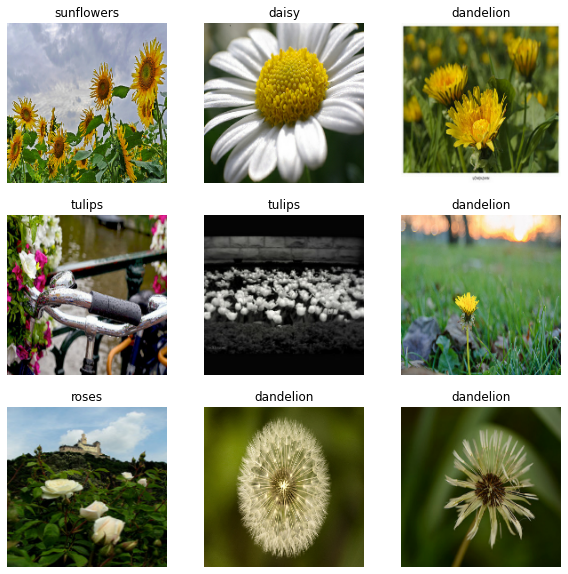

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
num_classes = len(class_names)
print(num_classes)
from tensorflow.python.keras.callbacks import TensorBoard 
from datetime import date

5


In [9]:
def generate_model(gene):
    print('create model for ' + str(gene))
    model = Sequential()
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
    for i in range (gene[0]):
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        if gene[i+1] == 1:
            model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    # model.summary()
    return model

In [11]:
''' train '''
def train(model, epochs, nmb_of_generation, gene):
    # log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    today = date.today()

    # dd/mm/YY
    d1 = today.strftime("%d-%m-%Y")
    # tensorboard = TensorBoard(log_dir=)
    
    log = "logs/" +"varianta_elitista_2" + "/"+ str(nmb_of_generation) + "/" + str(gene)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log, histogram_freq=1)
    # loss_history = LossHistory()
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1,
            callbacks=[tensorboard_callback]
        )
    except tf.errors.ResourceExhaustedError as e:
        print('\n ResourceExhausted Error: Cannot allocate enough memory')
        return -1
    return history.history['val_accuracy']

In [12]:
def generate_initial_generation(nmb_indiv):
    arr = []
    for i in range(nmb_indiv):
        while True:
            nmb_layers = np.array([np.random.randint(2,6)])
            gene = np.random.randint(2,size=nmb_layers)
            poz_for_maxpooling = np.random.randint(0,nmb_layers)
            gene[poz_for_maxpooling] = 1
            gene = np.concatenate((nmb_layers, gene), axis=0)
            
            ok = True
            for el in arr:
                if np.array_equal(el, gene):
                    ok = False
            if ok:
                break
            
        arr.append(gene)
    arr = np.asarray(arr)
    print('Individuals:')
    print(arr)
    return arr

In [23]:

generate_initial_generation(11)

Individuals:
[array([3, 1, 1, 1]) array([4, 0, 1, 0, 1]) array([3, 1, 0, 0])
 array([4, 1, 1, 1, 1]) array([5, 1, 1, 1, 1, 0]) array([4, 0, 1, 1, 1])
 array([4, 1, 0, 0, 1]) array([5, 1, 1, 1, 0, 1]) array([4, 0, 0, 1, 1])
 array([4, 1, 1, 1, 0]) array([5, 0, 0, 1, 0, 1])]


C:\Users\sorana\AppData\Local\Temp/ipykernel_17152/2135233446.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asarray(arr)


array([array([3, 1, 1, 1]), array([4, 0, 1, 0, 1]), array([3, 1, 0, 0]),
       array([4, 1, 1, 1, 1]), array([5, 1, 1, 1, 1, 0]),
       array([4, 0, 1, 1, 1]), array([4, 1, 0, 0, 1]),
       array([5, 1, 1, 1, 0, 1]), array([4, 0, 0, 1, 1]),
       array([4, 1, 1, 1, 0]), array([5, 0, 0, 1, 0, 1])], dtype=object)

In [13]:
import random


def mutation(mutation_rate, offspring, debug):
    mutation_point = random.randint(0, offspring[0])
    if debug:
        print('mutation')
        print(offspring)
        print(mutation_point)
    is_mutated = random.randint(1, 100)
    if is_mutated < mutation_rate*100:
        if mutation_point != 0:
            offspring[mutation_point] = 1 - offspring[mutation_point]
        else:
            if offspring[0] == 2:
                rand = 1
            elif offspring[0] == 5:
                rand = 0
            else:
                rand = random.randint(0, 1)
                
            if rand==0:
                offspring = offspring[:-1]
                offspring[0] = offspring[0] - 1
            else:
                addon = random.randint(0, 1)
                offspring = np.append(offspring, addon)
                offspring[0] = offspring[0] + 1 
    return offspring
    

def create_offspring(parent1, parent2, crossover_point, debug):
    offspring = []
    if debug:
        print('parents:')
        print(parent1)
        print(parent2)
        print('crossover_point:')
        print(crossover_point)
    offspring.append(parent1[0])
    if crossover_point != parent1[0]:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])
        offspring = np.append(offspring, parent1[(crossover_point+1):])
    else:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])
    if debug:
        print('offspring')
        print(offspring)
        print('\n')
    return offspring


def update_generation(population, fitness, nmb_ind, mutation_rate, debug):
    # code cleanup, mutatia, prima antrenare  
    new_population = []
    pop=[]
    for idx, el in enumerate(population):
        pop.append([el, fitness[idx]])

    sorted_pop = sorted(pop, key=lambda agent: agent[1], reverse=True)
    new_population.append(sorted_pop[0][0])
    new_population.append(sorted_pop[1][0])
    sorted_pop.pop(0)
    sorted_pop.pop(0)
    print('elitist:')
    print(new_population)
    print('moving on')
    pop = sorted_pop
    for i in range(int((nmb_ind-2)/2)):
        parents = random.sample(pop, k=4)
        parents = sorted(parents, key=lambda agent: agent[1], reverse=True)
        crossover_point = random.randint(1, min(parents[0][0][0], parents[1][0][0]))
        
        par1 = parents[0][0]
        par2 = parents[1][0]
        
        check_dupl = 0
        while True:
            off1 = create_offspring(par1, par2, crossover_point, debug)
            ok = True
            for el in new_population:
                if np.array_equal(el, off1):
                    ok = False
            if ok==True:
                break
            check_dupl = check_dupl + 1
            if check_dupl > 3:
                break
        new_population.append(mutation(mutation_rate, off1, debug))
        
        check_dupl = 0
        while True:
            off2 = create_offspring(par2, par1, crossover_point, debug)
            ok = True
            for el in new_population:
                if np.array_equal(el, off2):
                    ok = False
            if ok==True:
                break
            check_dupl = check_dupl + 1
            if check_dupl > 3:
                break
        new_population.append(mutation(mutation_rate, off2, debug))
        
    new_population = np.asarray(new_population)
    return new_population


#
# pop = np.array([[2, 0, 0],
#                [2, 0, 1],
#                [2, 1, 0],
#                [2, 1, 0],
#                [3, 1, 1, 0],
#                [3, 1, 1, 1]
#                 ])
#
# fit = np.array([2, 1, 6, 4, 5, 7])
# print(update_generation(pop, fit, 6, 0.25, True))

In [43]:
pop = np.array([[2, 0, 0],
               [2, 1, 1],
               [2, 0, 0],
               [2, 1, 1],
               [3, 1, 1, 0],
               [3, 1, 1, 1]
                ])

fit = np.array([2, 1, 6, 4, 5, 7])
print(update_generation(pop, fit, 6, 0.25, True))

elitist:
[[3, 1, 1, 1], [2, 0, 0]]
moving on
parents:
[3, 1, 1, 0]
[2, 1, 1]
crossover_point:
2
offspring
[3 1 1 0]


mutation
[3 1 1 0]
3
parents:
[2, 1, 1]
[3, 1, 1, 0]
crossover_point:
2
offspring
[2 1 1]


mutation
[2 1 1]
1
parents:
[3, 1, 1, 0]
[2, 1, 1]
crossover_point:
2
offspring
[3 1 1 0]


parents:
[3, 1, 1, 0]
[2, 1, 1]
crossover_point:
2
offspring
[3 1 1 0]


parents:
[3, 1, 1, 0]
[2, 1, 1]
crossover_point:
2
offspring
[3 1 1 0]


parents:
[3, 1, 1, 0]
[2, 1, 1]
crossover_point:
2
offspring
[3 1 1 0]


mutation
[3 1 1 0]
1
parents:
[2, 1, 1]
[3, 1, 1, 0]
crossover_point:
2
offspring
[2 1 1]


mutation
[2 1 1]
1
[list([3, 1, 1, 1]) list([2, 0, 0]) array([3, 1, 1, 0]) array([2, 0, 1])
 array([3, 1, 1, 0]) array([2, 0, 1])]


C:\Users\sorana\AppData\Local\Temp/ipykernel_2408/2406076261.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pop = np.array([[2, 0, 0],
C:\Users\sorana\AppData\Local\Temp/ipykernel_2408/2430297964.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_population = np.asarray(new_population)


In [14]:
def train_by_GA(nmb_of_generations, nmb_ind_per_gen, nmb_of_epochs, mutation_rate, debug, generate_initial_population):
    if generate_initial_population:
        population = np.array(generate_initial_generation(nmb_ind_per_gen))
        fitness = np.zeros(nmb_ind_per_gen)
    else:
        population, fitness = data_recovery('D:\\facultate\\AF\\proiect\\cod\\GA_CNN\\logs\\varianta_elitista', 1)
        population = np.array(population)

    input('Press Enter to continue...')
    for gen in range(nmb_of_generations):
        print('generation: ' + str(gen))
        for idx_ind, gene in enumerate(population):
            print('individual' + str(idx_ind) + ":" + str(gene))
            model = generate_model(gene)
            hist = train(model, nmb_of_epochs, gen+1, gene)
            if hist == -1:
                fitness[idx_ind] = -1
            else:
                fitness[idx_ind] = hist[nmb_of_epochs-1]
        population = update_generation(population, fitness,  nmb_ind_per_gen, mutation_rate,debug)
        print('Updated population:')
        print(population)
        


In [16]:
train_by_GA(nmb_of_generations=5, nmb_ind_per_gen=12,nmb_of_epochs=6, mutation_rate=0.3, debug=False, generate_initial_population=True)

C:\Users\sorana\AppData\Local\Temp/ipykernel_3292/3314851731.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asarray(arr)


Individuals:
[array([4, 0, 0, 1, 0]) array([2, 1, 0]) array([4, 0, 1, 1, 1])
 array([3, 1, 1, 0]) array([4, 1, 0, 0, 0]) array([4, 0, 1, 0, 1])
 array([2, 1, 1]) array([5, 1, 0, 1, 0, 1]) array([5, 1, 1, 0, 0, 1])
 array([3, 1, 1, 1]) array([5, 1, 1, 1, 1, 1]) array([3, 1, 0, 1])]


Press Enter to continue... 


generation: 0
individual0:[4 0 0 1 0]
create model for [4 0 0 1 0]
Epoch 1/6
92/92 [==============================] - 257s 3s/step - loss: 1.6891 - accuracy: 0.4142 - val_loss: 1.2154 - val_accuracy: 0.5300
Epoch 2/6
92/92 [==============================] - 247s 3s/step - loss: 1.1803 - accuracy: 0.4969 - val_loss: 1.1004 - val_accuracy: 0.5436
Epoch 3/6
92/92 [==============================] - 241s 3s/step - loss: 1.1109 - accuracy: 0.5426 - val_loss: 1.1106 - val_accuracy: 0.5436
Epoch 4/6
92/92 [==============================] - 236s 3s/step - loss: 1.0653 - accuracy: 0.5831 - val_loss: 1.1166 - val_accuracy: 0.5450
Epoch 5/6
92/92 [==============================] - 246s 3s/step - loss: 1.0010 - accuracy: 0.6052 - val_loss: 1.0007 - val_accuracy: 0.6240
Epoch 6/6
92/92 [==============================] - 238s 3s/step - loss: 0.9552 - accuracy: 0.6250 - val_loss: 1.0084 - val_accuracy: 0.6158
individual1:[2 1 0]
create model for [2 1 0]
Epoch 1/6
92/92 [==============================]

C:\Users\sorana\AppData\Local\Temp/ipykernel_3292/2430297964.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_population = np.asarray(new_population)


Epoch 1/6
92/92 [==============================] - 90s 969ms/step - loss: 1.3664 - accuracy: 0.4084 - val_loss: 1.1250 - val_accuracy: 0.5341
Epoch 2/6
92/92 [==============================] - 89s 965ms/step - loss: 1.0355 - accuracy: 0.6008 - val_loss: 1.0575 - val_accuracy: 0.5654
Epoch 3/6
92/92 [==============================] - 90s 974ms/step - loss: 0.9514 - accuracy: 0.6298 - val_loss: 0.8873 - val_accuracy: 0.6458
Epoch 4/6
92/92 [==============================] - 89s 973ms/step - loss: 0.8844 - accuracy: 0.6591 - val_loss: 0.9040 - val_accuracy: 0.6580
Epoch 5/6
92/92 [==============================] - 90s 975ms/step - loss: 0.8433 - accuracy: 0.6751 - val_loss: 0.9063 - val_accuracy: 0.6431
Epoch 6/6
92/92 [==============================] - 90s 975ms/step - loss: 0.7927 - accuracy: 0.6962 - val_loss: 0.9385 - val_accuracy: 0.6362
individual1:[3 1 0 1]
create model for [3 1 0 1]
Epoch 1/6
92/92 [==============================] - 83s 886ms/step - loss: 1.6331 - accuracy: 0.3501

In [12]:
gene = np.asarray([3, 1, 1, 1])
model = generate_model(gene)
train(model, 6, 1, gene)
print('moving along')

create model for [3 1 1 1]
Epoch 1/6
92/92 [==============================] - 76s 811ms/step - loss: 1.3476 - accuracy: 0.4281 - val_loss: 1.2393 - val_accuracy: 0.4986
Epoch 2/6
92/92 [==============================] - 74s 800ms/step - loss: 1.0895 - accuracy: 0.5582 - val_loss: 1.0453 - val_accuracy: 0.5940
Epoch 3/6
92/92 [==============================] - 74s 802ms/step - loss: 0.9871 - accuracy: 0.6138 - val_loss: 0.9359 - val_accuracy: 0.6308
Epoch 4/6
92/92 [==============================] - 75s 816ms/step - loss: 0.9215 - accuracy: 0.6431 - val_loss: 0.9359 - val_accuracy: 0.6199
Epoch 5/6
92/92 [==============================] - 73s 790ms/step - loss: 0.8549 - accuracy: 0.6649 - val_loss: 0.8384 - val_accuracy: 0.6676
Epoch 6/6
92/92 [==============================] - 72s 779ms/step - loss: 0.8083 - accuracy: 0.6948 - val_loss: 0.8268 - val_accuracy: 0.6717
moving along


In [18]:
from tensorflow.python.framework import tensor_util
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import os


def data_recovery(path, last_succesfull_generation):
    path = path+"\\"+str(last_succesfull_generation)
    values = []
    roots_for_tf_event = []
    nr_gen = -1
    individuals_run = []
    for root, dirs, files in os.walk(path):
        if nr_gen == -1:
            nr_gen = len(dirs)
            individuals_run = dirs
        for filename in files:
            root_ = root.split("\\")
            if root_[-1] == 'validation':
                roots_for_tf_event.append(root.replace("\\", "/")+"/"+filename)
    print(nr_gen)
    values_for_individuals=[]
    idx = 0
    for path in roots_for_tf_event:
        idx = idx + 1
        value_to_add=-1
        for event in summary_iterator(path):
            for value in event.summary.value:
                if value.tag=='epoch_accuracy':
                    # print(type(tensor_util.MakeNdarray(value.tensor)))
                    value_to_add = tensor_util.MakeNdarray(value.tensor)
                    # print(value_to_add.item(0))
        values_for_individuals.append(value_to_add.item(0))
    print(len(values_for_individuals))
    true_values =[]
    for gene_string in individuals_run:
        gene = []
        for i in gene_string:
            if i.isdigit():
                gene.append(int(i))
        true_values.append(gene)
    print(true_values)
    return values_for_individuals, individuals_run


print(data_recovery('D:\\facultate\\AF\\proiect\\cod\\GA_CNN\\logs\\varianta_elitista', 1))

11
11
[[2, 0, 1], [2, 1, 0], [2, 1, 1], [3, 1, 0, 0], [3, 1, 1, 1], [4, 0, 0, 0, 1], [4, 1, 0, 0, 1], [4, 1, 1, 1, 1], [5, 0, 0, 0, 1, 1], [5, 1, 0, 1, 0, 1], [5, 1, 1, 1, 1, 1]]
([0.5844686627388, 0.6267030239105225, 0.6689373254776001, 0.6512261629104614, 0.6430517435073853, 0.6512261629104614, 0.6757493019104004, 0.6662125587463379, 0.6348773837089539, 0.6743869185447693, 0.7002725005149841], ['[2 0 1]', '[2 1 0]', '[2 1 1]', '[3 1 0 0]', '[3 1 1 1]', '[4 0 0 0 1]', '[4 1 0 0 1]', '[4 1 1 1 1]', '[5 0 0 0 1 1]', '[5 1 0 1 0 1]', '[5 1 1 1 1 1]'])
